## We use this file to test some functions and for debugging

In [2]:
from models import *
import torch
import torchvision
import torchvision.transforms as T 
from worker import *
import numpy as np

In [5]:
num_iter = 1000
delta = 1e-4
eps = 10
def reverse_eps(eps, num_iter, delta):
    return (np.sqrt(np.log(1/delta) + eps) - np.sqrt(np.log(1/delta)))**2 / num_iter
reverse_eps(eps, num_iter, delta)

0.0018173897078857042

In [2]:
l = torch.tensor([[1, 2, 3], [1, 2, 3]])
torch.sum(l, dim=0)

tensor([2, 4, 6])

In [3]:
torch.zeros(10)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [3]:
train_data = torchvision.datasets.MNIST(train = True, root = './data', download = True, 
                                        transform = T.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = 10)

In [4]:
# Update parameters
lr = 0.1
#model_size = len(tools.flatten(model.parameters()))
#print(model_size)
w = Worker(train_loader, train_loader, batch_size=10, model="simple_mnist_model", loss='CrossEntropyLoss', momentum=0.0, c_clip= 1, sigma_cdp= 0.,
                 num_labels= 10, criterion= "topk", num_evaluations= 100, device= "cpu", seed= 1)
for batch in train_loader:
    X, y = batch
    break
#t = w.compute_gradient(X, y)
w.compute_gradient(X, y)

[Parameter containing:
tensor([[-0.0056, -0.0033,  0.0032,  ...,  0.0325,  0.0225,  0.0186],
        [ 0.0262, -0.0266,  0.0073,  ..., -0.0088, -0.0100,  0.0067],
        [ 0.0310,  0.0324, -0.0077,  ..., -0.0289, -0.0163, -0.0028],
        ...,
        [ 0.0041,  0.0141,  0.0337,  ...,  0.0208, -0.0117, -0.0041],
        [ 0.0026, -0.0076,  0.0015,  ...,  0.0149,  0.0044, -0.0072],
        [ 0.0218, -0.0024, -0.0038,  ..., -0.0102,  0.0336,  0.0345]],
       requires_grad=True), Parameter containing:
tensor([ 0.0089, -0.0181,  0.0355, -0.0119,  0.0004, -0.0129,  0.0140, -0.0035,
        -0.0273,  0.0204, -0.0161,  0.0278, -0.0082, -0.0151, -0.0182, -0.0230,
        -0.0262,  0.0066,  0.0030, -0.0257, -0.0097, -0.0276, -0.0160,  0.0002,
        -0.0099, -0.0303,  0.0059,  0.0048,  0.0206, -0.0307,  0.0077,  0.0283,
         0.0042, -0.0258, -0.0164, -0.0302, -0.0166,  0.0166,  0.0220,  0.0264,
        -0.0149,  0.0177, -0.0269,  0.0318,  0.0206,  0.0294,  0.0068, -0.0268,
        -0.01

In [11]:

# Update parameters
lr = 0.1
model_size = len(tools.flatten(model.parameters()))
print(model_size)
momentum_gradient = torch.ones(model_size)
parameters = tools.flatten(model.parameters())
print(parameters)
for param, grad in zip(model.parameters(), momentum_gradient):
    param.data -=  lr * grad

print(tools.flatten(model.parameters()))

101770
tensor([ 0.0212, -0.0016, -0.0099,  ...,  0.0467, -0.0344, -0.0235],
       grad_fn=<CatBackward0>)
tensor([-0.0788, -0.1016, -0.1099,  ..., -0.0533, -0.1344, -0.1235],
       grad_fn=<CatBackward0>)


In [20]:
data = torch.tensor([[1, 2, 4], [3, 4, 5]])
weights = torch.tensor([0, 2])
res = torch.sum(weights.view(-1, 1).mul(data), dim = 0)
res

tensor([ 6,  8, 10])

In [22]:
t = torch.zeros((64, 101770))

# Get the memory usage in bytes
t_memory_bytes = t.element_size() * t.nelement()

print(f"Memory usage of the t: {t_memory_bytes} bytes")


Memory usage of the t: 26053120 bytes


## Testing if we get the desired user-privacy when we use $\sigma_{cdp} = \frac{\sigma_{ldp}}{\sqrt(n)}$

In [3]:
from utils import dp_account, topology
num_iter = 1500
target_eps = 10
delta = 1e-5
clip = 1
num_nodes = 64
target_eps_iter = dp_account.reverse_eps(target_eps, num_iter, delta)
print("target eps iter ", target_eps_iter)
sigma_ldp = clip * np.sqrt(2/target_eps_iter)
sigma_cdp = sigma_ldp/np.sqrt(num_nodes)

# degree matrix and adjacency
W_centr = topology.FixedMixingMatrix("centralized", num_nodes)
W_ring = topology.FixedMixingMatrix("ring", num_nodes)

# Privacy for centr
adjacency_matrix_1 = np.array(W_centr(0) != 0, dtype=float)
adjacency_matrix_1 = adjacency_matrix_1 - np.diag(np.diag(adjacency_matrix_1))
degree_matrix_1 = np.diag(adjacency_matrix_1 @ np.ones_like(adjacency_matrix_1[0]))

# Privacy for ring
adjacency_matrix_2 = np.array(W_ring(0) != 0, dtype=float)
adjacency_matrix_2 = adjacency_matrix_2 - np.diag(np.diag(adjacency_matrix_2))
degree_matrix_2 = np.diag(adjacency_matrix_2 @ np.ones_like(adjacency_matrix_2[0]))
print("Centr ", dp_account.rdp_account(sigmacdp= sigma_cdp, sigmacor = 0, clip = clip, degree_matrix= degree_matrix_1, adjacency_matrix = adjacency_matrix_1))
print("Ring LDP ", dp_account.rdp_account(sigmacdp= sigma_ldp, sigmacor = 0, clip = clip, degree_matrix= degree_matrix_2, adjacency_matrix = adjacency_matrix_2))



target eps iter  0.0010335701523836135
Centr  0.06614848975255126
Ring LDP  0.0010335701523836135


In [4]:
np.linspace(1, 4, 7)

array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ])

In [7]:
t1 = torch.ones(3)
t2 = torch.zeros(3)
l = []
l.append(t1)
l.append(t2)
l

[tensor([1., 1., 1.]), tensor([0., 0., 0.])]

In [12]:
t = torch.stack(l)
t.shape

torch.Size([2, 3])

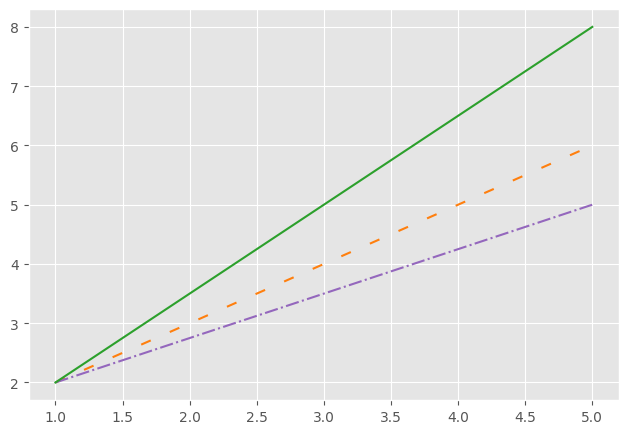

In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')
fig, ax = plt.subplots()
fig.set_size_inches(3 * 2.54, 2 * 2.54)
ax.plot(np.arange(1, 6), np.arange(2, 7), color = 'tab:orange', linestyle= (0, (5, 10)))
ax.plot(np.arange(1, 6), np.linspace(2, 5, 5), color = 'tab:purple', linestyle= '-.')
ax.plot(np.arange(1, 6), np.linspace(2, 8, 5), color = 'tab:green', linestyle= 'solid')

ax.grid(True)



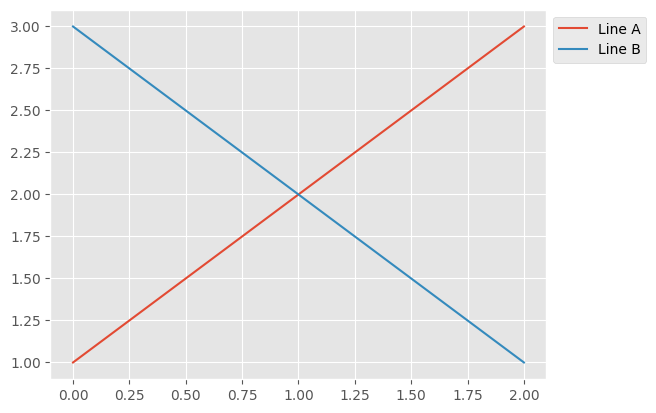

In [2]:
import matplotlib.pyplot as plt

# Create a sample plot
plt.plot([1, 2, 3], label='Line A')
plt.plot([3, 2, 1], label='Line B')

# Add a legend and specify its location outside the axes
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()


In [10]:
np.logspace(-5, -1, 10)

array([1.00000000e-05, 2.78255940e-05, 7.74263683e-05, 2.15443469e-04,
       5.99484250e-04, 1.66810054e-03, 4.64158883e-03, 1.29154967e-02,
       3.59381366e-02, 1.00000000e-01])